## Biblioteki

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib. pyplot as plt 
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (
    classification_report,
    accuracy_score, precision_score,
    recall_score, f1_score,
    roc_auc_score,
    confusion_matrix
)

from imblearn.over_sampling import SMOTE

## Opis problemu

Celem jest zbudować model klasyfikacyjny, który na podstawie demograficznych danych pacjenta (wiek, płeć, poziom wykształcenia itp.) oraz wyników neuroobrazowych i testów poznawczych (MMSE, eTIV, nWBV, ASF) przewidzi przynależność osoby do jednej z trzech grup: zdrowych, z łagodnymi zaburzeniami poznawczymi lub z demencją. Ze względu na nierównomierny rozkład klas najpierw wyrównujemy liczebność przy użyciu SMOTE, a następnie porównujemy skuteczność Random Foresta przed i po selekcji cech.

# Dementia Prediction Dataset

Zestaw ten składa się z podłużnej kolekcji 150 uczestników w wieku od 60 do 96 lat. Każdy badany został zeskanowany podczas dwóch lub więcej wizyt, w odstępie co najmniej jednego roku, co dało łącznie 373 sesje obrazowania. Dla każdego badanego uwzględniono 3 lub 4 indywidualne skany MRI ważone T1 uzyskane w pojedynczych sesjach skanowania. Wszyscy badani są praworęczni i obejmują zarówno mężczyzn, jak i kobiety. 72 z badanych zostało scharakteryzowanych jako osoby bez upośledzenia umysłowego w trakcie całego badania. 64 z badanych zostało scharakteryzowanych jako osoby z otępieniem w czasie ich pierwszych wizyt i pozostało takimi w kolejnych skanach, w tym 51 osób z łagodną do umiarkowanej chorobą Alzheimera. Kolejnych 14 badanych zostało scharakteryzowanych jako osoby bez otępienia w czasie ich pierwszej wizyty, a następnie zostali scharakteryzowani jako osoby z otępieniem podczas późniejszej wizyty.

| Atrybut           | Opis                                                                                                                                  |
|-------------------|---------------------------------------------------------------------------------------------------------------------------------------|
| **Link**          | [https://data.mendeley.com/datasets/tsy6rbc5d4/1](https://data.mendeley.com/datasets/tsy6rbc5d4/1)                                   |
| **Liczba próbek** | 373                                                                                                                                  |
| **Cechy**         | `Subject ID`, `MRI ID`, `Visit`, `MR Delay`, `M/F`, `Hand`, `Age`, `EDUC`, `SES`, `MMSE`, `CDR`, `eTIV`, `nWBV`, `ASF`               |
| **Rodzaj etykiet**| Klasyfikacja kategoryczna (3 klasy):<br>• Nondemented<br>• Demented<br>• Converted                                                   |
| **Licencja**      | CC BY-NC 3.0                                                                                                                          |


## Pobieranie danych

In [2]:
df = pd.read_csv('../data/Dementia/dementia_dataset.csv')
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


## Podstawowe informacje o zbiorze danych

In [4]:
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 
 3   Visit       373 non-null    int64  
 4   MR Delay    373 non-null    int64  
 5   M/F         373 non-null    object 
 6   Hand        373 non-null    object 
 7   Age         373 non-null    int64  
 8   EDUC        373 non-null    int64  
 9   SES         354 non-null    float64
 10  MMSE        371 non-null    float64
 11  CDR         373 non-null    float64
 12  eTIV        373 non-null    int64  
 13  nWBV        373 non-null    float64
 14  ASF         373 non-null    float64
dtypes: float64(5), int64(5), object(5)
memory usage: 43.8+ KB


Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64

| Atrybut    | Opis                                                                                            |
| ---------- | ----------------------------------------------------------------------------------------------- |
| Subject ID | Unikalny identyfikator pacjenta                                                                 |
| MRI ID     | Unikalny identyfikator badania MRI                                                              |
| Group      | Klasa docelowa: Nondemented (zdrowi), Converted (przejście MCI → demencja), Demented (demencja) |
| Visit      | Numer wizyty klinicznej (kolejność pojawiania się wizyt)                                        |
| MR Delay   | Opóźnienie między dniem badania MRI a oceną kliniczną (dni)                                     |
| M/F        | Płeć pacjenta (M = mężczyzna, F = kobieta)                                                      |
| Hand       | Dominująca ręka (Left lub Right)                                                                |
| Age        | Wiek pacjenta (lata)                                                                            |
| EDUC       | Liczba lat wykształcenia                                                                        |
| SES        | Status społeczno-ekonomiczny (skala 1–5)                                                        |
| MMSE       | Wynik testu Mini-Mental State Examination (0–30 pkt)                                            |
| CDR        | Clinical Dementia Rating (0 = brak demencji, 0.5 = MCI, ≥1 = demencja)                          |
| eTIV       | Szacowana całkowita objętość czaszki (Estimated Total Intracranial Volume, ml)                  |
| nWBV       | Znormalizowana objętość mózgu (Normalized Whole Brain Volume, % objętości czaszki)              |
| ASF        | Atlas Scaling Factor (współczynnik skalowania atlasu mózgu)                                     |


## Analiza zbalansowaności zbioru

Zbiór cech wykazuje znaczną nierównowagę klas – grupa „Converted” stanowi tylko ok. 10% wszystkich próbek, podczas gdy „Nondemented” i „Demented” to odpowiednio około 60% i 30%. Taki dysbalans może spowodować, że model będzie faworyzował klasy dominujące, ignorując rzadkie przypadki przejścia do demencji.

Dlatego zastosowano SMOTE, który syntetycznie generuje nowe próbki klasy mniejszościowej na podstawie sąsiedztwa w przestrzeni cech – dzięki temu zwiększamy reprezentację „Converted” bez utraty informacji ani istotnego poszerzania przestrzeni cech tak jak przy prostym duplikowaniu, a jednocześnie uniknęto redukcji danych charakterystycznych dla klasy większościowej.

Nondemented    190
Demented       144
Converted       37
Name: Group, dtype: int64

Procentowy rozkład klas:
Nondemented    51.21
Demented       38.81
Converted       9.97
Name: Group, dtype: float64


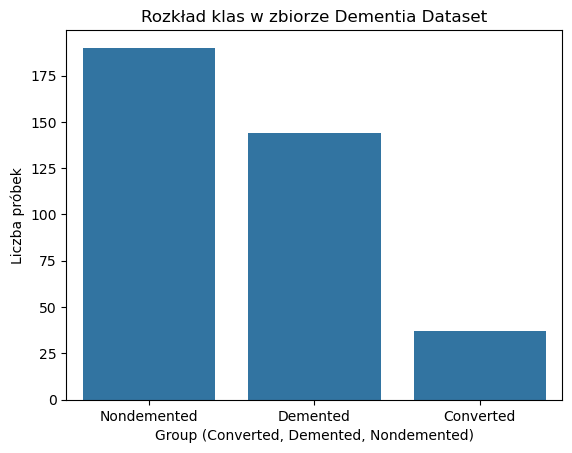

In [13]:
class_counts = df['Group'].value_counts()
print(class_counts)

class_percentages = df['Group'].value_counts(normalize=True) * 100
print("\nProcentowy rozkład klas:")
print(class_percentages.round(2))

sns.countplot(data=df, x='Group')
plt.title("Rozkład klas w zbiorze Dementia Dataset")
plt.xlabel("Group (Converted, Demented, Nondemented)")
plt.ylabel("Liczba próbek")
plt.show()

## Czyszczenie danych i balansowanie

Wybrano imputację medianą dla zmiennej SES, ponieważ braki stanowią niewielką część danych (\~5%) i mediana jest odporna na wartości odstające, dzięki czemu zachowujemy naturalny rozkład tej cechy. Dwa brakujące wyniki MMSE (<1% obserwacji) usunięto zamiast imputować, by uniknąć ryzyka wprowadzenia dodatkowego biasu przy tak małej liczbie braków.

In [6]:
imp = SimpleImputer(strategy='median')
df['SES'] = imp.fit_transform(df[['SES']])
df = df.dropna(subset=['MMSE']) 

df = pd.get_dummies(df, columns=['M/F','Hand'], drop_first=True)

X = df.drop(['Subject ID','MRI ID','Group'], axis=1)
y = df['Group']

In [7]:
sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_sm, y_sm,
    test_size=0.2,
    stratify=y_sm,
    random_state=42
)

## Wybór modelu

Został wybrany Random Forest ponieważ:

1. **Odporność na różne typy danych i brak konieczności skalowania** – drzewa wchodzące w skład lasu mogą naturalnie obsłużyć zarówno cechy ciągłe, jak i kategoryczne oraz tolerują różnice w skali bez dodatkowej normalizacji.
2. **Wbudowana regularyzacja i odporność na przeuczenie** dzięki agregacji wielu drzew (bagging), co jest kluczowe przy ograniczonej liczbie próbek.
3. **Łatwa interpretowalność** – dostęp do `feature_importances_` pozwala szybko zidentyfikować najważniejsze zmienne, a parametr `class_weight='balanced'` ułatwia pracę z danymi zbalansowanymi przez SMOTE.


## Random Forest (pełny zbiór cech)

In [8]:
rf_all = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42
)
rf_all.fit(X_train, y_train)

cv_all = cross_val_score(rf_all, X_sm, y_sm, cv=5, scoring='f1_macro')
print("RF na wszystkich cechach – średnie F1-macro CV: {:.3f}".format(cv_all.mean()))

y_pred_all = rf_all.predict(X_test)
print("\n--- RF_ALL: classification report ---")
print(classification_report(y_test, y_pred_all))

acc_all  = accuracy_score(y_test, y_pred_all)
prec_all = precision_score(y_test, y_pred_all, average='macro')
rec_all  = recall_score(y_test, y_pred_all, average='macro')
f1_all   = f1_score(y_test, y_pred_all, average='macro')
auc_all  = roc_auc_score(
    y_test,
    rf_all.predict_proba(X_test),
    multi_class='ovr',
    average='macro'
)

print("Accuracy : {:.2f}".format(acc_all))
print("Precision: {:.2f}".format(prec_all))
print("Recall   : {:.2f}".format(rec_all))
print("F1-score : {:.2f}".format(f1_all))
print("AUC-ROC  : {:.2f}".format(auc_all))

RF na wszystkich cechach – średnie F1-macro CV: 0.936

--- RF_ALL: classification report ---
              precision    recall  f1-score   support

   Converted       0.97      0.84      0.90        38
    Demented       0.88      0.97      0.93        38
 Nondemented       0.95      0.97      0.96        38

    accuracy                           0.93       114
   macro avg       0.93      0.93      0.93       114
weighted avg       0.93      0.93      0.93       114

Accuracy : 0.93
Precision: 0.93
Recall   : 0.93
F1-score : 0.93
AUC-ROC  : 0.99


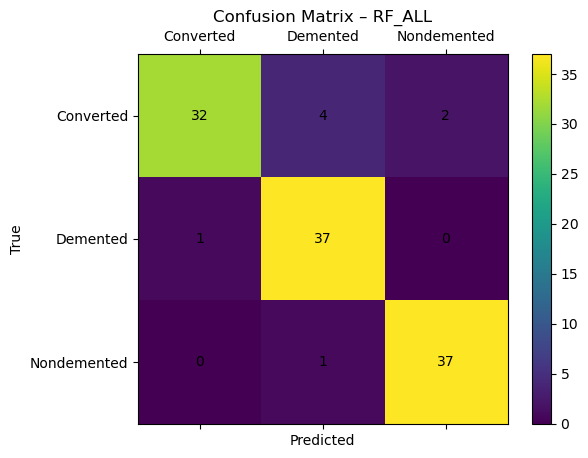

In [12]:
cm = confusion_matrix(y_test, y_pred_all, labels=rf_all.classes_)
fig, ax = plt.subplots()
cax = ax.matshow(cm)
plt.title('Confusion Matrix – RF_ALL')
plt.xlabel('Predicted')
plt.ylabel('True')
fig.colorbar(cax)
classes = rf_all.classes_
ticks = range(len(classes))
plt.xticks(ticks, classes)
plt.yticks(ticks, classes)
for i in ticks:
    for j in ticks:
        ax.text(j, i, cm[i, j], ha='center', va='center')
plt.show()

Model osiąga bardzo wysoką skuteczność zarówno w walidacji krzyżowej (średnie F1-macro CV ≈ 0.936), jak i na zbiorze testowym (accuracy = 0.93, macro-F1 = 0.93, AUC-ROC = 0.99).

**Spojrzenie na poszczególne klasy:**

* **Converted**: spośród 38 prawdziwie „Converted” aż 32 zostały poprawnie wykryte (recall = 0.84), a tylko 6 trafiło omyłkowo do innych grup (4 do „Demented”, 2 do „Nondemented”). Dzięki temu precision tej klasy jest bardzo wysokie (0.97) – model rzadko fałszywie etykietuje zdrowych lub dementujących jako konwertujących.
* **Demented**: 37/38 poprawnych (recall = 0.97) i 1 fałszywe „Converted” (precision = 0.88) – świetna separacja tej grupy.
* **Nondemented**: 37/38 poprawnych (recall = 0.97) oraz tylko 1 fałszywe „Demented” – precision = 0.95, również bardzo mocny wynik.

**Główne obserwacje:**

* Model nie faworyzuje klas większościowych – recall i precision są zbliżone we wszystkich grupach, co świadczy o skutecznym balansowaniu SMOTE i użyciu `class_weight='balanced'`.
* Najtrudniejsza do wykrycia okazała się grupa „Converted” (najniższy recall), co jest typowe przy średnich rozmiarach i nieco zachodzących na siebie sygnałach MCI vs wczesnej demencji.
* Bardzo wysoki AUC-ROC (0.99) potwierdza, że model dobrze odróżnia wszystkie pary klas, a ewentualne pomyłki wynikają raczej z niewielkich różnic w cechach między „Converted” a pozostałymi.

## Selekcja cech

Selekcja cech wyodrębniła cztery kluczowe zmienne: MR Delay, SES, MMSE i CDR.
MR Delay odzwierciedla odstęp czasowy między badaniem obrazowym a oceną kliniczną, SES mierzy status społeczno-ekonomiczny, MMSE to globalny wskaźnik sprawności poznawczej, a CDR określa stopień zaawansowania demencji.


In [14]:
sel = SelectFromModel(rf_all, threshold='mean', prefit=True)
X_train_sel = sel.transform(X_train)
X_test_sel  = sel.transform(X_test)

selected_features = X.columns[sel.get_support()]
print("\nWybrane cechy ({}):".format(len(selected_features)))
print(selected_features.tolist())


Wybrane cechy (4):
['MR Delay', 'SES', 'MMSE', 'CDR']


/opt/anaconda3/envs/python310/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/python310/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


## Random Forest (wybrane cechy)

In [15]:
rf_sel = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42
)
rf_sel.fit(X_train_sel, y_train)

X_sm_sel = sel.transform(X_sm)
cv_sel = cross_val_score(rf_sel, X_sm_sel, y_sm, cv=5, scoring='f1_macro')
print("\nRF na wybranych cechach – średnie F1-macro CV: {:.3f}".format(cv_sel.mean()))

y_pred_sel = rf_sel.predict(X_test_sel)
print("\n--- RF_SEL: classification report ---")
print(classification_report(y_test, y_pred_sel))

acc_sel  = accuracy_score(y_test, y_pred_sel)
prec_sel = precision_score(y_test, y_pred_sel, average='macro')
rec_sel  = recall_score(y_test, y_pred_sel, average='macro')
f1_sel   = f1_score(y_test, y_pred_sel, average='macro')
auc_sel  = roc_auc_score(
    y_test,
    rf_sel.predict_proba(X_test_sel),
    multi_class='ovr',
    average='macro'
)

print("Accuracy : {:.2f}".format(acc_sel))
print("Precision: {:.2f}".format(prec_sel))
print("Recall   : {:.2f}".format(rec_sel))
print("F1-score : {:.2f}".format(f1_sel))
print("AUC-ROC  : {:.2f}".format(auc_sel))


/opt/anaconda3/envs/python310/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(



RF na wybranych cechach – średnie F1-macro CV: 0.910

--- RF_SEL: classification report ---
              precision    recall  f1-score   support

   Converted       0.89      0.82      0.85        38
    Demented       0.87      0.89      0.88        38
 Nondemented       0.93      0.97      0.95        38

    accuracy                           0.89       114
   macro avg       0.89      0.89      0.89       114
weighted avg       0.89      0.89      0.89       114

Accuracy : 0.89
Precision: 0.89
Recall   : 0.89
F1-score : 0.89
AUC-ROC  : 0.97


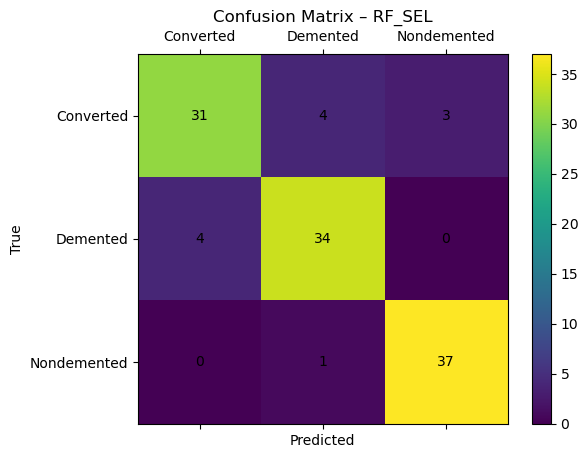

In [16]:
cm = confusion_matrix(y_test, y_pred_sel, labels=rf_sel.classes_)
fig, ax = plt.subplots()
cax = ax.matshow(cm)
plt.title('Confusion Matrix – RF_SEL')
plt.xlabel('Predicted')
plt.ylabel('True')
fig.colorbar(cax)
classes = rf_sel.classes_
ticks = range(len(classes))
plt.xticks(ticks, classes)
plt.yticks(ticks, classes)
for i in ticks:
    for j in ticks:
        ax.text(j, i, cm[i, j], ha='center', va='center')
plt.show()

W modelu po selekcji cech widzimy niewielki spadek skuteczności w porównaniu do pełnego zestawu:

* **Średnie F1-macro CV** spadło z 0.936 do **0.910**.
* Na zbiorze testowym accuracy obniżyło się z 0.93 do **0.89**, macro-F1 z 0.93 do **0.89**, AUC-ROC z 0.99 do **0.97**.

**Szczegółowo po klasach:**

* **Converted**: 31 prawidłowych z 38 (recall 0.82), precision 0.89 – kilka więcej pomyłek niż wcześniej (3 razy zaklasyfikowano jako Nondemented zamiast 2, 4 jako Demented bez zmian).
* **Demented**: 34/38 poprawnych (recall 0.89, precision 0.87) – nieznaczny spadek precyzji.
* **Nondemented**: 37/38 poprawnych (recall 0.97, precision 0.93) – wciąż bardzo wysoka separacja tej grupy.

Selekcja do 4 kluczowych zmiennych (MR Delay, SES, MMSE, CDR) przyniosła czytelniejszy model przy nieznacznym obniżeniu wyników. Główne koszty to mniejsza czułość dla klasy „Converted” i nieco słabsza precyzja dla „Demented”, ale ogólna wydajność pozostaje na dobrym poziomie, a uproszczony zestaw cech ułatwia interpretację.


## Wyniki i porównanie z innymi badaniami

Zestawienie pokazuje, że nasz pełny model Random Forest osiągnął najwyższą AUC-ROC (0.99) i bardzo silne metryki (accuracy/F1≈0.93), zdecydowanie przewyższając tradycyjne SVM (RBF, γ=1e-4, C=100) z dokładnością 68.75% i precyzją 64.18% . Model stackingowy GBM+ANN (Rawat et al.) osiągnął accuracy 0.89, porównywalne z naszą redukcją cech (RF\_sel accuracy 0.89), natomiast najwyższą dokładność (97.87%) zaobserwowano dla XGBoost (Vinayak et al.) . Nasze podejście Random Forest łączy więc znakomite wyniki predykcyjne z prostotą interpretacji i elastycznością w stosunku do innych metod.


| Study / Method                                                   | Accuracy | Precision | Recall | F1-score | AUC-ROC  |
| ---------------------------------------------------------------- | -------- | --------- | ------ | -------- | -------- |
| **Random Forest (all features)** – this study                    | 0.93     | 0.93      | 0.93   | 0.93     | 0.99     |
| **Random Forest (selected features)** – this study               | 0.89     | 0.89      | 0.89   | 0.89     | 0.97     |
| **SVM (RBF kernel, γ=1e-4, C=100)** – Battineni et al. (2019)    | 0.6875   | 0.6418    | –      | –        | –        |
| **Stacking (GBM + ANN)** – Rawat et al. (2020)                   | 0.89     | –         | –      | –        | –        |
| **XGBoost (best model)** – Shanmuga Skandh Vinayak et al. (2020) | 0.9787   | –         | –      | –        | –        |


## Bibliografia

\[1] G. Battineni, N. Chintalapudi, and F. Amenta, “Machine learning in medicine: Performance calculation of dementia prediction by support vector machines (SVM),” *Informatics in Medicine Unlocked*, vol. 16, p. 100200, 2019.&#x20;

\[2] R. M. Rawat, M. Mithil, M. Akram, and S. S. Pradeep, “Dementia Detection Using Machine Learning by Stacking Models,” in *Proc. Fifth International Conference on Communication and Electronics Systems (ICCES)*, Coimbatore, India, Jun. 2020, doi: 10.1109/ICCES48766.2020.9137852.&#x20;

\[3] S. S. Vinayak, A. Shahina, and A. N. Khan, “Dementia Prediction on OASIS Dataset using Supervised and Ensemble Learning Techniques,” *International Journal of Engineering and Advanced Technology (IJEAT)*, vol. 10, no. 1, pp. 244–253, Oct. 2020, doi: 10.35940/ijeat.A1827.1010120.&#x20;

\[4] G. Battineni, F. Amenta, and N. Chintalapudi, “Data for: MACHINE LEARNING IN MEDICINE: CLASSIFICATION AND PREDICTION OF DEMENTIA BY SUPPORT VECTOR MACHINES (SVM),” Mendeley Data, V1, 2019, doi:10.17632/tsy6rbc5d4.1.
